# Building an ARIMA model for time series forecasting of river flow data


In [1]:
# import data and view as plot
from arima_functions import *
import pandas as pd
import matplotlib.pyplot as plt

# import data - using data from the Brahamaputra River, Bangladesh
file_path = "DATA/2651100_Q_Day.Cmd.txt"
metadata, data = read_data(file_path)
station_info, parsed_data = process_data(metadata, data)

print("Station Information:")
print(station_info)
print("Data:")
print(parsed_data.head())


Station Information:
{'GRDC-No.': '2651100', 'River': 'BRAHMAPUTRA RIVER', 'Station': 'BAHADURABAD', 'Country': 'BD', 'Latitude (DD)': '25.18', 'Longitude (DD)': '89.67', 'Catchment area (km²)': None, 'Altitude (m ASL)': '19.0', 'Time series': '1985-04 - 1992-03', 'No. of years': '8', 'Last update': '2018-05-29'}
Data:
         Date   Value
0  1985-04-03  6370.0
1  1985-04-04  6320.0
2  1985-04-05  6290.0
3  1985-04-06  6350.0
4  1985-04-07  6920.0


<Figure size 1000x600 with 0 Axes>

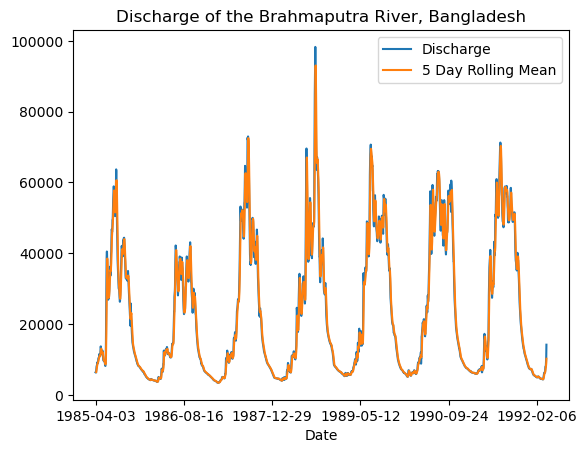

In [2]:
# plot the data
plt.figure(figsize=(10,6))
parsed_data.plot(y='Value', x='Date', title='Discharge of the Brahmaputra River, Bangladesh')
# add rolling mean value    
parsed_data['Value'].rolling(window=5).mean().plot()
parsed_data['Avg'] = parsed_data['Value'].rolling(window=5).mean()
plt.legend(['Discharge', '5 Day Rolling Mean'])
plt.show()





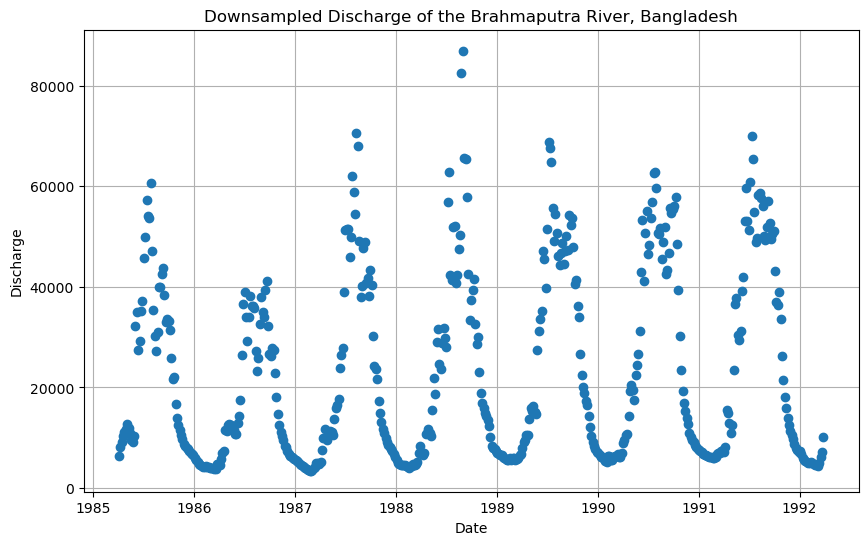

In [3]:
# Convert 'Date' column to datetime if it's not already
parsed_data['Date'] = pd.to_datetime(parsed_data['Date'])

# Set 'Date' column as the index of the DataFrame
parsed_data.set_index('Date', inplace=True)

# Downsample the data by averaging every 5 days
parsed_data['Sampled'] = parsed_data['Value'].resample('5D').mean()

# Plot the downsampled data
plt.figure(figsize=(10, 6))
plt.plot(parsed_data['Sampled'], marker='o', linestyle='-')
plt.title('Downsampled Discharge of the Brahmaputra River, Bangladesh')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True)
plt.show()


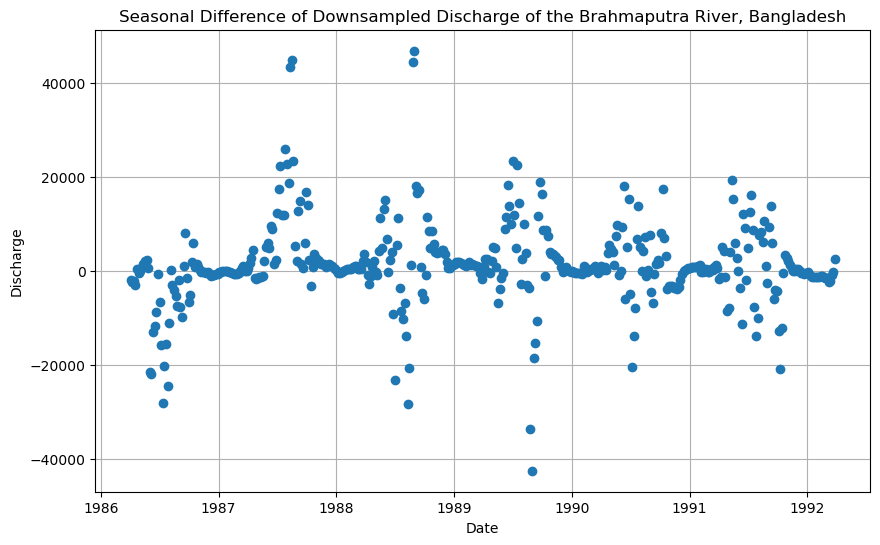

In [4]:
# as data will be seasonal, do seasonal differencing
parsed_data['Seasonal Difference'] = (parsed_data['Sampled'] - parsed_data['Sampled'].shift(365))
plt.figure(figsize=(10, 6))
plt.plot(parsed_data['Seasonal Difference'], marker='o', linestyle='-')
plt.title('Seasonal Difference of Downsampled Discharge of the Brahmaputra River, Bangladesh')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True)
plt.show()


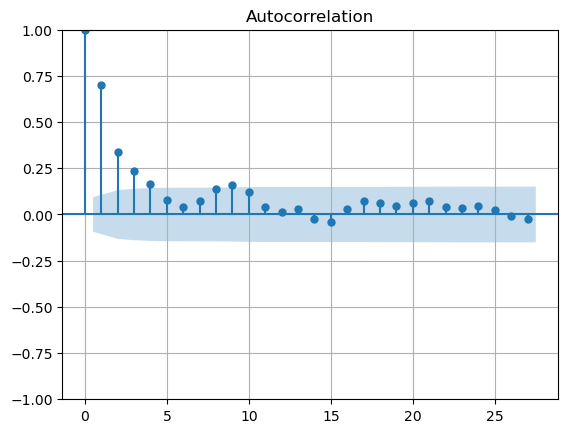

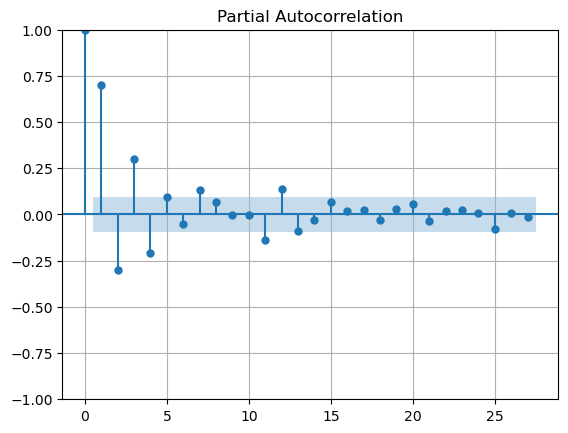

In [5]:
# calculate the ACF and PACF to determine order of ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(parsed_data['Seasonal Difference'].dropna())
grid = plt.grid(True)
plot_pacf(parsed_data['Seasonal Difference'].dropna())
grid = plt.grid(True)
# plot_acf(parsed_data['Avg'].dropna())
# plot_pacf(parsed_data['Avg'].dropna())
# plot_acf(parsed_data['First Difference'].dropna())
# plot_pacf(parsed_data['First Difference'].dropna())

Roughly reading from these plots:
- Predict around 1-2 auto-regressive terms
- 0 non-seasonal differences
- 2 lagged forecast errors

and for the seasonal component:
- 0 auto-regressive terms
- 1 seasonal difference
- 0 lagged forecast errors
with a seasonal period of 73 (365/5 due to down-sampling)

In [32]:
# choose best model and fit it (as well as some nearby  variations)
from statsmodels.tsa.arima.model import ARIMA

# split data into training (50:50) and testing
split = 0.8
train = parsed_data['Sampled'].iloc[:int(len(parsed_data)*split)]
test = parsed_data['Sampled'].iloc[int(len(parsed_data)*split):]

model = ARIMA(train.dropna(), order=(2,0,2), seasonal_order=(0,1,0,73))
model_fit = model.fit()
print(model_fit.summary())



/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)
/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)
/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                           Sampled   No. Observations:                  409
Model:             ARIMA(2, 0, 2)x(0, 1, [], 73)   Log Likelihood               -3394.976
Date:                           Fri, 01 Mar 2024   AIC                           6799.952
Time:                                   13:08:56   BIC                           6819.037
Sample:                               04-03-1985   HQIC                          6807.560
                                    - 11-03-1990                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1893      0.159      7.480      0.000       0.878       1.501
ar.L2         -0.2697      0.091     -2.968

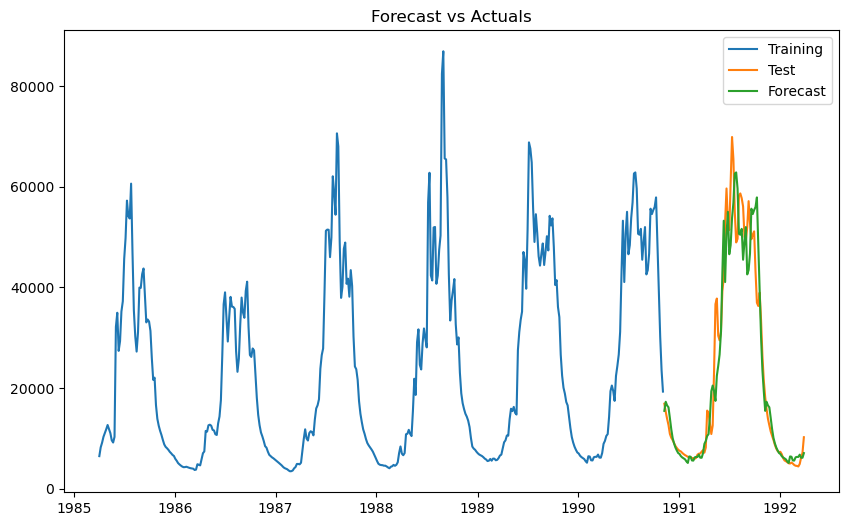

In [34]:
# predict the future using the model and plot the results
forecast = model_fit.forecast(steps=int(len(test)/5))
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()



In [49]:
# find best model
import itertools

# Define parameters for ARIMA orders
p = range(0,5)  # AutoRegressive (AR) order
d = [0]  # Integrated (I) order data is already stationary and downsampled
q = range(0, 3)  # Moving Average (MA) order

# Define seasonal parameters for ARIMA seasonal orders
P = [0]  # Seasonal AutoRegressive (SAR) order
D = range(0,2)  # Seasonal Integrated (SI) order 
Q = [0]  # Seasonal Moving Average (SMA) order
s = [73]  # Seasonal period 

# Generate all possible combinations of parameters
orders = list(itertools.product(p, d, q))
seasonal_orders = list(itertools.product(P, D, Q, s))

best_aic = float('inf')
best_model = None

# Iterate over all combinations of parameters and fit the models
for order in orders:
    for seasonal_order in seasonal_orders:
        try:
            model = ARIMA(train.dropna(), order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()

            # Check if the current model has a lower AIC value than the best model found so far
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_model = model_fit
                best_order = order
                best_seasonal_order = seasonal_order

        except:
            continue

# Print the summary of the best model
print("Best Model:")
print(best_model.summary())
print("Best AIC:", best_aic)
print("Best ARIMA Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)

# store the model
# best_model.save('bramaputra_best_model.pkl')

/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)
/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)
/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)
/Users/philblecher/opt/miniconda3/envs/IntrotoAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5D will be used.
  self._init_dates(dates, freq)
/Users/philblecher/opt/miniconda3/en

Best Model:
                                     SARIMAX Results                                     
Dep. Variable:                           Sampled   No. Observations:                  409
Model:             ARIMA(3, 0, 2)x(0, 1, [], 73)   Log Likelihood               -3386.523
Date:                           Fri, 01 Mar 2024   AIC                           6785.047
Time:                                   13:17:51   BIC                           6807.949
Sample:                               04-03-1985   HQIC                          6794.176
                                    - 11-03-1990                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4497      0.080     -5.618      0.000      -0.607      -0.293
ar.L2          0.2289      0.06

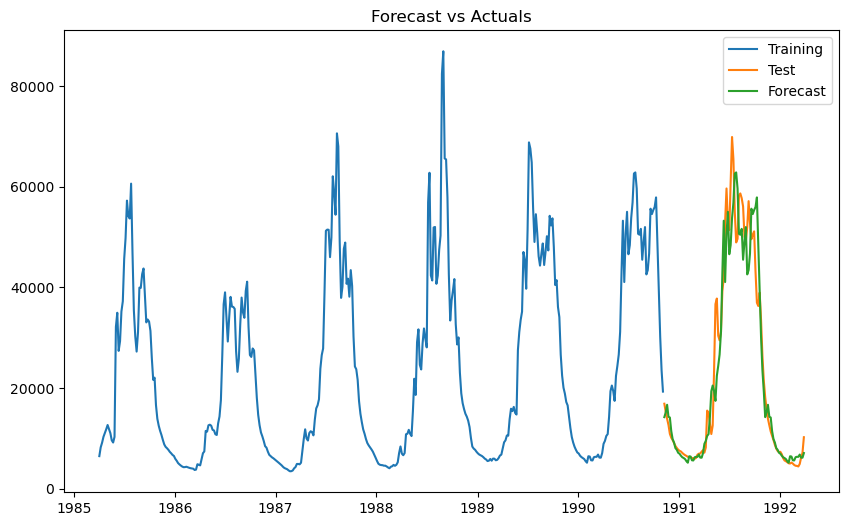

In [51]:
# predict the future using the model and plot the results
forecast = best_model.forecast(steps=int(len(test)/5))
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [50]:
# evaluate the model using RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test, forecast))
print("RMSE:", rmse)

ValueError: Found input variables with inconsistent numbers of samples: [511, 102]